# Neural Storyteller - Image Captioning with Seq2Seq

**Dataset:** Flickr30k  
**Platform:** Kaggle  
**GPU:** T4 x2

## Part 1: Feature Extraction

In [1]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory.")

class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s] 
Extracting Features: 100%|██████████| 249/249 [01:43<00:00,  2.40it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


## Part 2: Vocabulary & Text Preprocessing

In [2]:
import pandas as pd
from collections import Counter

with open('flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)

print(f"Loaded {len(features_dict)} image features")

Loaded 31783 image features


In [3]:
def find_captions_file():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        for f in files:
            if 'caption' in f.lower() and f.endswith(('.txt', '.csv')):
                return os.path.join(root, f)
    return None

CAPTIONS_FILE = find_captions_file()
print(f"Captions: {CAPTIONS_FILE}")

Captions: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt


In [4]:
import re

def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z0-9\s']", '', caption)
    caption = ' '.join(caption.split())
    return caption

def load_captions(filepath):
    captions_dict = {}
    
    if filepath.endswith('.csv'):
        df = pd.read_csv(filepath, sep=',')
        img_col = 'image' if 'image' in df.columns else df.columns[0]
        cap_col = 'caption' if 'caption' in df.columns else df.columns[1]
            
        for _, row in df.iterrows():
            img_name = row[img_col]
            caption = str(row[cap_col])
            if img_name not in captions_dict:
                captions_dict[img_name] = []
            captions_dict[img_name].append(clean_caption(caption))
    else:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        start_idx = 1 if 'image' in lines[0].lower() else 0
        
        for line in lines[start_idx:]:
            parts = line.strip().split(',', 1) if ',' in line else line.strip().split('|', 1)
            if len(parts) >= 2:
                img_name = parts[0].strip()
                caption = parts[1].strip()
                if '#' in img_name:
                    img_name = img_name.split('#')[0]
                if img_name not in captions_dict:
                    captions_dict[img_name] = []
                captions_dict[img_name].append(clean_caption(caption))
    
    return captions_dict

captions_dict = load_captions(CAPTIONS_FILE)
print(f"Loaded captions for {len(captions_dict)} images")

sample_img = list(captions_dict.keys())[0]
print(f"\nSample: {sample_img}")
for i, cap in enumerate(captions_dict[sample_img][:2]):
    print(f"  {i+1}. {cap}")

Loaded captions for 31783 images

Sample: 1000092795.jpg
  1. two young guys with shaggy hair look at their hands while hanging out in the yard
  2. two young white males are outside near many bushes


In [5]:
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()
        
        self.pad_token = '<pad>'
        self.start_token = '<start>'
        self.end_token = '<end>'
        self.unk_token = '<unk>'
        
        self.word2idx = {self.pad_token: 0, self.start_token: 1, self.end_token: 2, self.unk_token: 3}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        
    def build_vocabulary(self, captions_dict):
        for img_name, captions in captions_dict.items():
            for caption in captions:
                self.word_freq.update(caption.split())
        
        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"Vocabulary size: {len(self.word2idx)}")
    
    def encode(self, caption):
        tokens = caption.split()
        encoded = [self.word2idx[self.start_token]]
        encoded += [self.word2idx.get(token, self.word2idx[self.unk_token]) for token in tokens]
        encoded.append(self.word2idx[self.end_token])
        return encoded
    
    def decode(self, indices):
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, self.unk_token)
            if word == self.end_token:
                break
            if word not in [self.start_token, self.pad_token]:
                words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(captions_dict)

test_caption = list(captions_dict.values())[0][0]
encoded = vocab.encode(test_caption)
decoded = vocab.decode(encoded)
print(f"Original: {test_caption}")
print(f"Decoded: {decoded}")

Vocabulary size: 7731
Original: two young guys with shaggy hair look at their hands while hanging out in the yard
Decoded: two young guys with shaggy hair look at their hands while hanging out in the yard


In [6]:
from sklearn.model_selection import train_test_split

valid_images = [img for img in features_dict.keys() if img in captions_dict]
print(f"Valid images: {len(valid_images)}")

train_images, temp_images = train_test_split(valid_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

print(f"Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

Valid images: 31783
Train: 25426, Val: 3178, Test: 3179


In [7]:
class CaptionDataset(Dataset):
    def __init__(self, image_names, features_dict, captions_dict, vocab, max_len=50):
        self.samples = []
        self.max_len = max_len
        self.vocab = vocab
        
        for img_name in image_names:
            feature = features_dict[img_name]
            for caption in captions_dict[img_name]:
                self.samples.append((feature, caption))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        feature, caption = self.samples[idx]
        encoded = self.vocab.encode(caption)
        
        if len(encoded) > self.max_len:
            encoded = encoded[:self.max_len]
        else:
            encoded = encoded + [self.vocab.word2idx[self.vocab.pad_token]] * (self.max_len - len(encoded))
        
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(encoded, dtype=torch.long)

MAX_LEN = 50
train_dataset = CaptionDataset(train_images, features_dict, captions_dict, vocab, MAX_LEN)
val_dataset = CaptionDataset(val_images, features_dict, captions_dict, vocab, MAX_LEN)
test_dataset = CaptionDataset(test_images, features_dict, captions_dict, vocab, MAX_LEN)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 127130, Val: 15890, Test: 15895


## Part 3: Seq2Seq Model

In [8]:
class Encoder(nn.Module):
    def __init__(self, feature_dim=2048, hidden_size=512):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(feature_dim, hidden_size)
        
    def forward(self, features):
        return self.fc(features)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, captions, hidden, cell):
        embeddings = self.embedding(captions)
        outputs, (hidden, cell) = self.lstm(embeddings, (hidden, cell))
        outputs = self.fc(outputs)
        return outputs, hidden, cell

class Seq2SeqCaptioner(nn.Module):
    def __init__(self, vocab_size, feature_dim=2048, embed_size=256, hidden_size=512, num_layers=1):
        super(Seq2SeqCaptioner, self).__init__()
        self.encoder = Encoder(feature_dim, hidden_size)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size, num_layers)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, features, captions):
        batch_size = features.size(0)
        encoded = self.encoder(features)
        
        hidden = encoded.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        
        outputs, _, _ = self.decoder(captions[:, :-1], hidden, cell)
        return outputs
    
    def greedy_search(self, features, vocab, max_len=50):
        self.eval()
        batch_size = features.size(0)
        device = features.device
        
        with torch.no_grad():
            encoded = self.encoder(features)
            hidden = encoded.unsqueeze(0).repeat(self.num_layers, 1, 1)
            cell = torch.zeros_like(hidden)
            
            word_idx = torch.tensor([[vocab.word2idx[vocab.start_token]]] * batch_size).to(device)
            generated = []
            
            for _ in range(max_len):
                output, hidden, cell = self.decoder(word_idx, hidden, cell)
                word_idx = output.argmax(dim=2)
                generated.append(word_idx)
                if (word_idx == vocab.word2idx[vocab.end_token]).all():
                    break
            
            generated = torch.cat(generated, dim=1)
        
        return [vocab.decode(generated[i].cpu().tolist()) for i in range(batch_size)]
    
    def beam_search(self, features, vocab, beam_width=5, max_len=50):
        self.eval()
        device = features.device
        
        with torch.no_grad():
            encoded = self.encoder(features)
            hidden = encoded.unsqueeze(0).repeat(self.num_layers, 1, 1)
            cell = torch.zeros_like(hidden)
            
            start_token = vocab.word2idx[vocab.start_token]
            end_token = vocab.word2idx[vocab.end_token]
            
            beams = [(0.0, [start_token], hidden, cell)]
            completed = []
            
            for _ in range(max_len):
                candidates = []
                for score, seq, h, c in beams:
                    if seq[-1] == end_token:
                        completed.append((score, seq))
                        continue
                    
                    word_idx = torch.tensor([[seq[-1]]]).to(device)
                    output, new_h, new_c = self.decoder(word_idx, h, c)
                    log_probs = torch.log_softmax(output[0, 0], dim=0)
                    top_probs, top_indices = log_probs.topk(beam_width)
                    
                    for i in range(beam_width):
                        candidates.append((score + top_probs[i].item(), seq + [top_indices[i].item()], new_h, new_c))
                
                if not candidates:
                    break
                candidates.sort(key=lambda x: x[0], reverse=True)
                beams = candidates[:beam_width]
            
            for score, seq, _, _ in beams:
                completed.append((score, seq))
            
            if completed:
                completed.sort(key=lambda x: x[0] / len(x[1]), reverse=True)
                return vocab.decode(completed[0][1])
            return vocab.decode([start_token])

VOCAB_SIZE = len(vocab)
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqCaptioner(VOCAB_SIZE, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Using 2 GPUs
Total parameters: 8,571,187


## Part 4: Training

In [9]:
import torch.optim as optim

BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Batches per epoch: {len(train_loader)}")

Batches per epoch: 1987


In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for features, captions in tqdm(loader, desc="Training"):
        features, captions = features.to(device), captions.to(device)
        
        optimizer.zero_grad()
        outputs = model(features, captions)
        
        loss = criterion(outputs.reshape(-1, VOCAB_SIZE), captions[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for features, captions in tqdm(loader, desc="Validating"):
            features, captions = features.to(device), captions.to(device)
            outputs = model(features, captions)
            loss = criterion(outputs.reshape(-1, VOCAB_SIZE), captions[:, 1:].reshape(-1))
            total_loss += loss.item()
    
    return total_loss / len(loader)

In [11]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved!")


Epoch 1/30


Training:   0%|          | 0/1987 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return F.linear(input, self.weight, self.bias)
Validating: 100%|██████████| 249/249 [00:04<00:00, 54.23it/s]


Train Loss: 3.6597, Val Loss: 3.2330
Model saved!

Epoch 2/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.53it/s]


Train Loss: 3.0079, Val Loss: 3.0499
Model saved!

Epoch 3/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.50it/s]


Train Loss: 2.7701, Val Loss: 2.9937
Model saved!

Epoch 4/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.70it/s]


Train Loss: 2.6019, Val Loss: 2.9857
Model saved!

Epoch 5/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 53.83it/s]


Train Loss: 2.4646, Val Loss: 2.9991

Epoch 6/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.43it/s]


Train Loss: 2.3468, Val Loss: 3.0312

Epoch 7/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.03it/s]


Train Loss: 2.2445, Val Loss: 3.0749

Epoch 8/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 53.97it/s]


Train Loss: 2.1521, Val Loss: 3.1129

Epoch 9/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.66it/s]


Train Loss: 2.0705, Val Loss: 3.1641

Epoch 10/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.64it/s]


Train Loss: 1.9976, Val Loss: 3.2134

Epoch 11/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.47it/s]


Train Loss: 1.9310, Val Loss: 3.2690

Epoch 12/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.63it/s]


Train Loss: 1.8714, Val Loss: 3.3270

Epoch 13/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.62it/s]


Train Loss: 1.8177, Val Loss: 3.3745

Epoch 14/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.34it/s]


Train Loss: 1.7697, Val Loss: 3.4277

Epoch 15/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.13it/s]


Train Loss: 1.7253, Val Loss: 3.4809

Epoch 16/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.26it/s]


Train Loss: 1.6841, Val Loss: 3.5325

Epoch 17/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 53.58it/s]


Train Loss: 1.6480, Val Loss: 3.5864

Epoch 18/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.70it/s]


Train Loss: 1.6143, Val Loss: 3.6341

Epoch 19/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.40it/s]


Train Loss: 1.5848, Val Loss: 3.6868

Epoch 20/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.56it/s]


Train Loss: 1.5568, Val Loss: 3.7323

Epoch 21/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.57it/s]


Train Loss: 1.5323, Val Loss: 3.7843

Epoch 22/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.25it/s]


Train Loss: 1.5078, Val Loss: 3.8251

Epoch 23/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.38it/s]


Train Loss: 1.4869, Val Loss: 3.8713

Epoch 24/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.48it/s]


Train Loss: 1.4670, Val Loss: 3.9161

Epoch 25/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.42it/s]


Train Loss: 1.4494, Val Loss: 3.9575

Epoch 26/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.63it/s]


Train Loss: 1.4324, Val Loss: 3.9989

Epoch 27/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.67it/s]


Train Loss: 1.4185, Val Loss: 4.0375

Epoch 28/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.53it/s]


Train Loss: 1.4029, Val Loss: 4.0776

Epoch 29/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.60it/s]


Train Loss: 1.3888, Val Loss: 4.1059

Epoch 30/30


Validating: 100%|██████████| 249/249 [00:04<00:00, 54.56it/s]

Train Loss: 1.3771, Val Loss: 4.1485


## Evaluation

In [12]:
print(f"Initial loss: {val_losses[0]:.4f}")
print(f"Best loss: {best_val_loss:.4f}")
print(f"Improvement: {((val_losses[0] - best_val_loss) / val_losses[0] * 100):.1f}%")

Initial loss: 3.2330
Best loss: 2.9857
Improvement: 7.6%


In [13]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print("Best model loaded")

Best model loaded


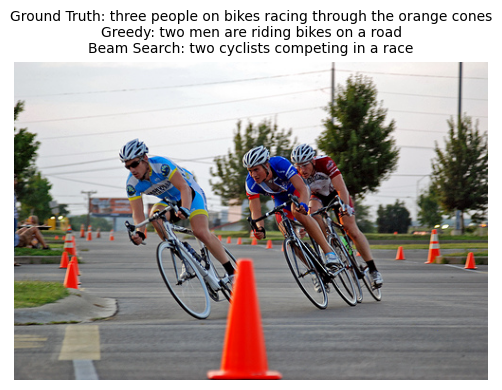

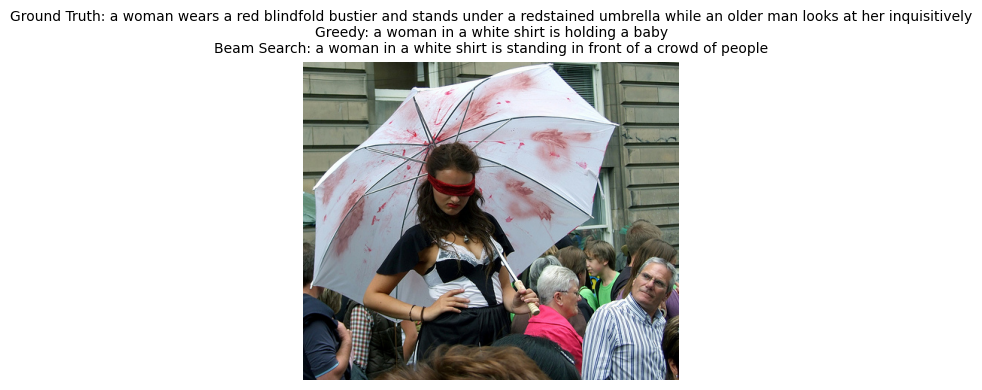

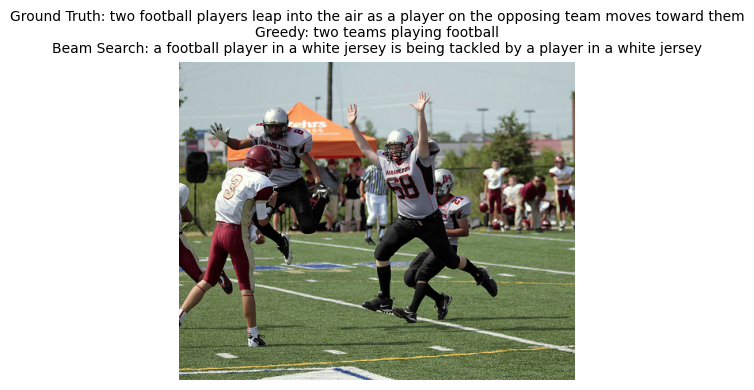

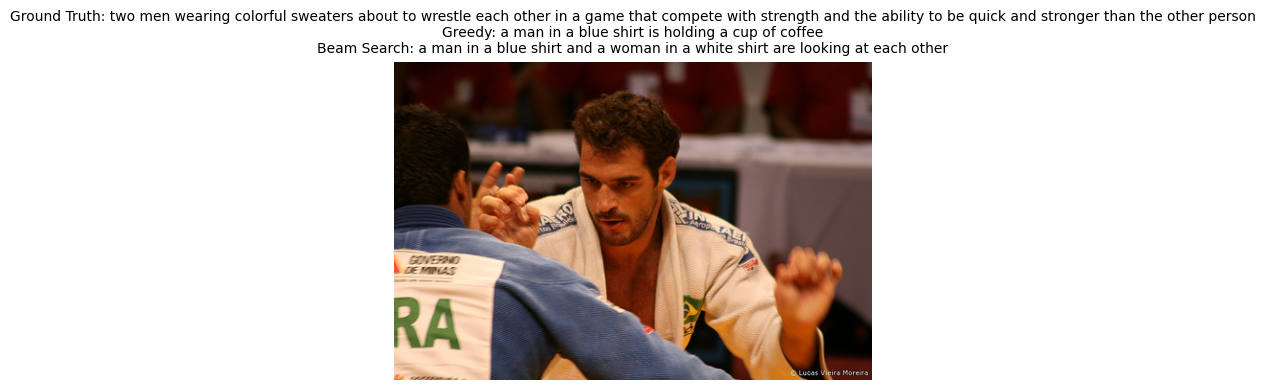

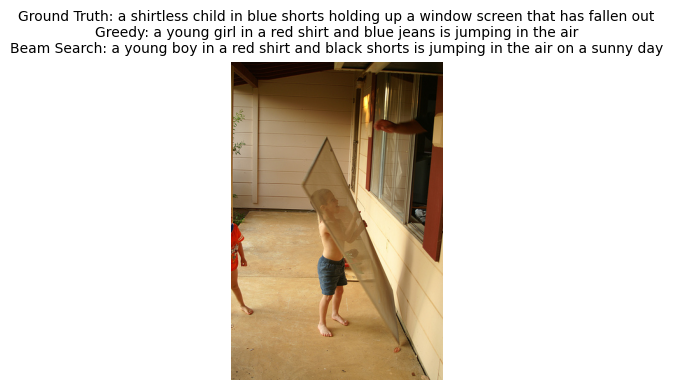

In [14]:
import matplotlib.pyplot as plt
import random

def display_captions(model, test_images, features_dict, captions_dict, vocab, device, num_samples=5):
    sample_images = random.sample(test_images, num_samples)
    
    for img_name in sample_images:
        feature = torch.tensor(features_dict[img_name], dtype=torch.float32).unsqueeze(0).to(device)
        
        if hasattr(model, 'module'):
            predicted = model.module.greedy_search(feature, vocab)[0]
            beam_pred = model.module.beam_search(feature, vocab)
        else:
            predicted = model.greedy_search(feature, vocab)[0]
            beam_pred = model.beam_search(feature, vocab)
        
        ground_truth = captions_dict[img_name][0]
        
        img_path = os.path.join(IMAGE_DIR, img_name)
        img = Image.open(img_path)
        
        plt.figure(figsize=(10, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Ground Truth: {ground_truth}\nGreedy: {predicted}\nBeam Search: {beam_pred}", fontsize=10)
        plt.tight_layout()
        plt.show()

display_captions(model, test_images, features_dict, captions_dict, vocab, device, num_samples=5)

### Quantitative Evaluation

In [15]:
!pip install nltk rouge-score -q

In [16]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from collections import defaultdict

nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

def evaluate_model(model, test_images, features_dict, captions_dict, vocab, device):
    model.eval()
    
    all_references = []
    all_hypotheses = []
    bleu_scores = {'bleu1': [], 'bleu2': [], 'bleu3': [], 'bleu4': []}
    meteor_scores = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    smooth = SmoothingFunction()
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    for img_name in tqdm(test_images, desc="Evaluating"):
        feature = torch.tensor(features_dict[img_name], dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            if hasattr(model, 'module'):
                predicted = model.module.beam_search(feature, vocab)
            else:
                predicted = model.beam_search(feature, vocab)
        
        references = [caption.split() for caption in captions_dict[img_name]]
        hypothesis = predicted.split()
        
        all_references.append(references)
        all_hypotheses.append(hypothesis)
        
        bleu_scores['bleu1'].append(sentence_bleu(references, hypothesis, weights=(1, 0, 0, 0), smoothing_function=smooth.method1))
        bleu_scores['bleu2'].append(sentence_bleu(references, hypothesis, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1))
        bleu_scores['bleu3'].append(sentence_bleu(references, hypothesis, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1))
        bleu_scores['bleu4'].append(sentence_bleu(references, hypothesis, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1))
        
        meteor_scores.append(meteor_score(references, hypothesis))
        
        rouge = scorer.score(' '.join(references[0]), ' '.join(hypothesis))
        rouge_scores['rouge1'].append(rouge['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(rouge['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(rouge['rougeL'].fmeasure)
    
    print("\n=== Evaluation Metrics ===")
    print(f"BLEU-1: {sum(bleu_scores['bleu1']) / len(bleu_scores['bleu1']):.4f}")
    print(f"BLEU-2: {sum(bleu_scores['bleu2']) / len(bleu_scores['bleu2']):.4f}")
    print(f"BLEU-3: {sum(bleu_scores['bleu3']) / len(bleu_scores['bleu3']):.4f}")
    print(f"BLEU-4: {sum(bleu_scores['bleu4']) / len(bleu_scores['bleu4']):.4f}")
    print(f"METEOR: {sum(meteor_scores) / len(meteor_scores):.4f}")
    print(f"ROUGE-1: {sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1']):.4f}")
    print(f"ROUGE-2: {sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2']):.4f}")
    print(f"ROUGE-L: {sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL']):.4f}")
    
    return bleu_scores, meteor_scores, rouge_scores

metrics = evaluate_model(model, test_images, features_dict, captions_dict, vocab, device)

Evaluating: 100%|██████████| 3179/3179 [06:25<00:00,  8.24it/s]


=== Evaluation Metrics ===
BLEU-1: 0.5468
BLEU-2: 0.3595
BLEU-3: 0.2285
BLEU-4: 0.1482
METEOR: 0.3625
ROUGE-1: 0.3153
ROUGE-2: 0.0941
ROUGE-L: 0.2757


### Token-Level Precision, Recall, F1

In [17]:
!pip install scikit-learn -q

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

def token_level_metrics(model, test_images, features_dict, captions_dict, vocab, device):
    model.eval()
    all_pred_tokens = []
    all_true_tokens = []
    
    for img_name in tqdm(test_images, desc="Token Metrics"):
        feature = torch.tensor(features_dict[img_name], dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            if hasattr(model, 'module'):
                predicted = model.module.beam_search(feature, vocab)
            else:
                predicted = model.beam_search(feature, vocab)
        
        reference = captions_dict[img_name][0]
        pred_tokens = set(predicted.split())
        ref_tokens = set(reference.split())
        
        all_tokens = list(pred_tokens | ref_tokens)
        pred_vec = [1 if token in pred_tokens else 0 for token in all_tokens]
        ref_vec = [1 if token in ref_tokens else 0 for token in all_tokens]
        
        all_pred_tokens.extend(pred_vec)
        all_true_tokens.extend(ref_vec)
    
    precision = precision_score(all_true_tokens, all_pred_tokens, zero_division=0)
    recall = recall_score(all_true_tokens, all_pred_tokens, zero_division=0)
    f1 = f1_score(all_true_tokens, all_pred_tokens, zero_division=0)
    
    print("\n=== Token-Level Metrics ===")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return precision, recall, f1

token_metrics = token_level_metrics(model, test_images, features_dict, captions_dict, vocab, device)

Token Metrics: 100%|██████████| 3179/3179 [06:06<00:00,  8.67it/s]



=== Token-Level Metrics ===
Precision: 0.3462
Recall: 0.2394
F1-Score: 0.2831


## Gradio Deployment

In [19]:
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 11.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.6 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
langchain-core 0.3.79 requires packaging<26.0.0,>=23.2.0, but you have packaging 26.0rc2 which is incompatible.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.


In [20]:
import gradio as gr
from torchvision import transforms

def generate_caption(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)
        resnet.eval()
        feature = resnet(img_tensor).view(1, -1)
    
    if hasattr(model, 'module'):
        caption = model.module.beam_search(feature, vocab)
    else:
        caption = model.beam_search(feature, vocab)
    
    return caption

interface = gr.Interface(
    fn=generate_caption,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Generated Caption"),
    title="Neural Storyteller - Image Captioning",
    description="Upload an image to generate a caption using Seq2Seq"
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ffabe71ac688883ff1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [21]:
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print("Vocabulary saved!")

Vocabulary saved!


In [24]:
!pip install huggingface_hub -q

In [29]:
app_code = '''import gradio as gr
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import pickle

class Encoder(nn.Module):
    def __init__(self, feature_dim=2048, hidden_size=512):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(feature_dim, hidden_size)
        
    def forward(self, features):
        return self.fc(features)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, captions, hidden, cell):
        embeddings = self.embedding(captions)
        outputs, (hidden, cell) = self.lstm(embeddings, (hidden, cell))
        outputs = self.fc(outputs)
        return outputs, hidden, cell

class Seq2SeqCaptioner(nn.Module):
    def __init__(self, vocab_size, feature_dim=2048, embed_size=256, hidden_size=512, num_layers=1):
        super(Seq2SeqCaptioner, self).__init__()
        self.encoder = Encoder(feature_dim, hidden_size)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size, num_layers)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, features, captions):
        batch_size = features.size(0)
        encoded = self.encoder(features)
        
        hidden = encoded.unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)
        
        outputs, _, _ = self.decoder(captions[:, :-1], hidden, cell)
        return outputs
    
    def beam_search(self, features, vocab, beam_width=5, max_len=50):
        self.eval()
        device = features.device
        
        with torch.no_grad():
            encoded = self.encoder(features)
            hidden = encoded.unsqueeze(0).repeat(self.num_layers, 1, 1)
            cell = torch.zeros_like(hidden)
            
            start_token = vocab.word2idx[vocab.start_token]
            end_token = vocab.word2idx[vocab.end_token]
            
            beams = [(0.0, [start_token], hidden, cell)]
            completed = []
            
            for _ in range(max_len):
                candidates = []
                for score, seq, h, c in beams:
                    if seq[-1] == end_token:
                        completed.append((score, seq))
                        continue
                    
                    word_idx = torch.tensor([[seq[-1]]]).to(device)
                    output, new_h, new_c = self.decoder(word_idx, h, c)
                    log_probs = torch.log_softmax(output[0, 0], dim=0)
                    top_probs, top_indices = log_probs.topk(beam_width)
                    
                    for i in range(beam_width):
                        candidates.append((score + top_probs[i].item(), seq + [top_indices[i].item()], new_h, new_c))
                
                if not candidates:
                    break
                candidates.sort(key=lambda x: x[0], reverse=True)
                beams = candidates[:beam_width]
            
            for score, seq, _, _ in beams:
                completed.append((score, seq))
            
            if completed:
                completed.sort(key=lambda x: x[0] / len(x[1]), reverse=True)
                return vocab.decode(completed[0][1])
            return vocab.decode([start_token])

class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.pad_token = '<pad>'
        self.start_token = '<start>'
        self.end_token = '<end>'
        self.unk_token = '<unk>'
    
    def decode(self, indices):
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, self.unk_token)
            if word == self.end_token:
                break
            if word not in [self.start_token, self.pad_token]:
                words.append(word)
        return ' '.join(words)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

VOCAB_SIZE = len(vocab.word2idx)
model = Seq2SeqCaptioner(VOCAB_SIZE, embed_size=256, hidden_size=512, num_layers=1).to(device)

state_dict = torch.load('best_model.pth', map_location=device)
if list(state_dict.keys())[0].startswith('module.'):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model.eval()

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet.eval()

def generate_caption(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        feature = resnet(img_tensor).view(1, -1)
    
    caption = model.beam_search(feature, vocab)
    return caption

demo = gr.Interface(
    fn=generate_caption,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Generated Caption"),
    title="Neural Storyteller - Image Captioning",
    description="Upload an image to generate a caption using Seq2Seq",
    theme=gr.themes.Soft()
)

if __name__ == "__main__":
    demo.launch()
'''

with open('app.py', 'w') as f:
    f.write(app_code)

requirements = '''torch>=2.0.0
torchvision>=0.15.0
gradio>=4.0.0
Pillow>=9.0.0
numpy>=1.24.0
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements)

readme = '''---
title: Neural Storyteller
emoji: 🖼️
colorFrom: blue
colorTo: purple
sdk: gradio
sdk_version: 4.0.0
app_file: app.py
pinned: false
---

# Neural Storyteller - Image Captioning

Seq2Seq model for image captioning trained on Flickr30k.
'''

with open('README.md', 'w') as f:
    f.write(readme)

print("Deployment files created!")

Deployment files created!


In [30]:
from huggingface_hub import HfApi, create_repo
from getpass import getpass

hf_token = getpass("c")
space_name = input("storyteller")

api = HfApi()
username = api.whoami(token=hf_token)['name']

try:
    repo_id = f"{username}/{space_name}"
    create_repo(repo_id=repo_id, token=hf_token, repo_type="space", space_sdk="gradio")
    print(f"Space created: {repo_id}")
except Exception as e:
    print(f"Space may already exist: {e}")
    repo_id = f"{username}/{space_name}"

api.upload_file(
    path_or_fileobj="app.py",
    path_in_repo="app.py",
    repo_id=repo_id,
    repo_type="space",
    token=hf_token
)

api.upload_file(
    path_or_fileobj="requirements.txt",
    path_in_repo="requirements.txt",
    repo_id=repo_id,
    repo_type="space",
    token=hf_token
)

api.upload_file(
    path_or_fileobj="README.md",
    path_in_repo="README.md",
    repo_id=repo_id,
    repo_type="space",
    token=hf_token
)

api.upload_file(
    path_or_fileobj="best_model.pth",
    path_in_repo="best_model.pth",
    repo_id=repo_id,
    repo_type="space",
    token=hf_token
)

api.upload_file(
    path_or_fileobj="vocab.pkl",
    path_in_repo="vocab.pkl",
    repo_id=repo_id,
    repo_type="space",
    token=hf_token
)

print(f"\n✅ Deployed successfully!")
print(f"🌐 Your app: https://huggingface.co/spaces/{repo_id}")

c ········
storyteller stoory


Space created: momina0/stoory


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            


✅ Deployed successfully!
🌐 Your app: https://huggingface.co/spaces/momina0/stoory
